In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load libraries
import matplotlib.pyplot as plt
import pandas as pd
import pickle
import numpy as np
import os
from tensorflow.keras.applications.resnet50 import ResNet50
from keras.optimizers import Adam
from keras.layers import Dense, Flatten,Input, Convolution2D, Dropout, LSTM, TimeDistributed, Embedding, Bidirectional, Activation, RepeatVector,Concatenate
from keras.models import Sequential, Model
from tensorflow.keras.utils import load_img, img_to_array
from keras.utils import np_utils
import random
from keras.preprocessing import image
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [ ]:
# Load data
images_dir = os.listdir("/content/drive/MyDrive/Flickr_Data/Flickr_Data/")

images_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Images/'
captions_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr8k.token.txt'
train_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.trainImages.txt'
val_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.devImages.txt'
test_path = '/content/drive/MyDrive/Flickr_Data/Flickr_Data/Flickr_TextData/Flickr_8k.testImages.txt'

captions = open(captions_path, 'r').read().split("\n")
x_train = open(train_path, 'r').read().split("\n")
x_val = open(val_path, 'r').read().split("\n")
x_test = open(test_path, 'r').read().split("\n")

In [ ]:
# Loading captions as values and images as key in dictionary
tokens = {}

for ix in range(len(captions)-1):
    temp = captions[ix].split("#")
    if temp[0] in tokens:
        tokens[temp[0]].append(temp[1][2:])
    else:
        tokens[temp[0]] = [temp[1][2:]]

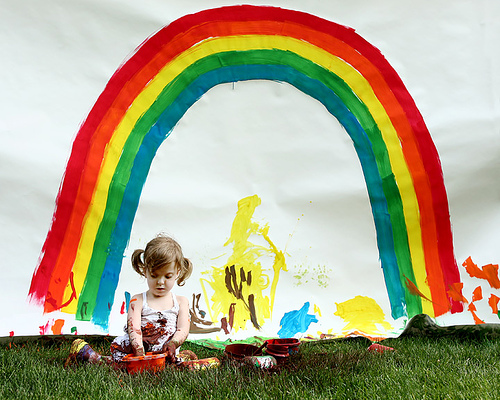

A little girl covered in paint sits in front of a painted rainbow with her hands in a bowl .
A little girl is sitting in front of a large painted rainbow .
A small girl in the grass plays with fingerpaints in front of a white canvas with a rainbow on it .
There is a girl with pigtails sitting in front of a rainbow painting .
Young girl with pigtails painting outside in the grass .


In [ ]:
# displaying an image and captions given to it
temp = captions[10].split("#")
from IPython.display import Image, display
z = Image(filename=images_path+temp[0])
display(z)

for ix in range(len(tokens[temp[0]])):
    print(tokens[temp[0]][ix])

In [ ]:
# Creating train, test and validation dataset files with header as 'image_id' and 'captions'
train_dataset = open('flickr_8k_train_dataset.txt','wb')
train_dataset.write(b"image_id\tcaptions\n")

val_dataset = open('flickr_8k_val_dataset.txt','wb')
val_dataset.write(b"image_id\tcaptions\n")

test_dataset = open('flickr_8k_test_dataset.txt','wb')
test_dataset.write(b"image_id\tcaptions\n")

18

In [ ]:
# Populating the above created files for train, test and validation dataset with image ids and captions for each of these images
for img in x_train:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        train_dataset.write((img+"\t"+caption+"\n").encode())
        train_dataset.flush()
train_dataset.close()

for img in x_test:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        test_dataset.write((img+"\t"+caption+"\n").encode())
        test_dataset.flush()
test_dataset.close()

for img in x_val:
    if img == '':
        continue
    for capt in tokens[img]:
        caption = "<start> "+ capt + " <end>"
        val_dataset.write((img+"\t"+caption+"\n").encode())
        val_dataset.flush()
val_dataset.close()

In [ ]:
# Loading 50 layer Residual Network Model and getting the summary of the model
model = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')
model.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [ ]:
# Helper function to process images
def preprocessing(img_path):
    im = load_img(img_path, target_size=(224,224,3))
    im = img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
train_data = {}
ctr=0
for ix in x_train:
    if ix == "":
        continue
    if ctr >= 3000:
        break
    ctr+=1
    if ctr%1000==0:
        print(ctr)
    path = images_path + ix
    img = preprocessing(path)
    pred = model.predict(img).reshape(2048)
    train_data[ix] = pred

1/1 [==============================] - 0s 25ms/step
1000
1/1 [==============================] - 0s 34ms/step
2000
1/1 [==============================] - 0s 28ms/step
3000
1/1 [==============================] - 0s 26ms/step


In [ ]:
train_data['2513260012_03d33305cf.jpg'].shape

(2048,)

In [ ]:
# opening train_encoded_images.p file and dumping it's content
with open( "train_encoded_images.p", "wb" ) as pickle_f:
    pickle.dump(train_data, pickle_f )

In [ ]:
# Loading image and its corresponding caption into a dataframe and then storing values from dataframe into 'ds'
pd_dataset = pd.read_csv("flickr_8k_train_dataset.txt", delimiter='\t')
ds = pd_dataset.values
print(ds.shape)

(30000, 2)


In [ ]:
pd_dataset.head()

,image_id,captions
0,2513260012_03d33305cf.jpg,<start> A black dog is running after a white d...
1,2513260012_03d33305cf.jpg,<start> Black dog chasing brown dog through sn...
2,2513260012_03d33305cf.jpg,<start> Two dogs chase each other across the s...
3,2513260012_03d33305cf.jpg,<start> Two dogs play together in the snow . <...
4,2513260012_03d33305cf.jpg,<start> Two dogs running through a low lying b...


In [ ]:
# Storing all the captions from ds into a list
sentences = []
for ix in range(ds.shape[0]):
    sentences.append(ds[ix, 1])

print(len(sentences))

30000


In [ ]:
# First 5 captions stored in sentences
sentences[:5]

['<start> A black dog is running after a white dog in the snow . <end>',
 '<start> Black dog chasing brown dog through snow <end>',
 '<start> Two dogs chase each other across the snowy ground . <end>',
 '<start> Two dogs play together in the snow . <end>',
 '<start> Two dogs running through a low lying body of water . <end>']

In [ ]:
# Splitting each captions stored in 'sentences' and storing them in 'words' as list of list
words = [i.split() for i in sentences]

In [ ]:
# Creating a list of all unique words
unique = []
for i in words:
    unique.extend(i)
unique = list(set(unique))

print(len(unique))

vocab_size = len(unique)

8253


In [ ]:
# Vectorization
word_to_indices = {val:index for index, val in enumerate(unique)}
indices_to_word = {index:val for index, val in enumerate(unique)}

In [ ]:
word_to_indices['UNK'] = 0
word_to_indices['raining'] = 8253

In [ ]:
indices_to_word[0] = 'UNK'
indices_to_word[8253] = 'raining'

In [ ]:
print(word_to_indices['<start>'])
print(indices_to_word[4011])
print(word_to_indices['<end>'])
print(indices_to_word[8051])

4867
tunnel
6421
sort


In [ ]:
vocab_size = len(word_to_indices.keys())
print(vocab_size)

8254


In [ ]:
max_len = 0

for i in sentences:
    i = i.split()
    if len(i) > max_len:
        max_len = len(i)

print(max_len)

40


In [ ]:
padded_sequences, subsequent_words = [], []

for ix in range(ds.shape[0]):
    partial_seqs = []
    next_words = []
    text = ds[ix, 1].split()
    text = [word_to_indices[i] for i in text]
    for i in range(1, len(text)):
        partial_seqs.append(text[:i])
        next_words.append(text[i])
    padded_partial_seqs = pad_sequences(partial_seqs, max_len, padding='post')

    next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=bool)

    #Vectorization
    for i,next_word in enumerate(next_words):
        next_words_1hot[i, next_word] = 1

    padded_sequences.append(padded_partial_seqs)
    subsequent_words.append(next_words_1hot)

padded_sequences = np.asarray(padded_sequences)
subsequent_words = np.asarray(subsequent_words)

print(padded_sequences.shape)
print(subsequent_words.shape)

<ipython-input-25-d76e392b112e>:13: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  next_words_1hot = np.zeros([len(next_words), vocab_size], dtype=np.bool)


(30000,)
(30000,)


<ipython-input-25-d76e392b112e>:22: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  padded_sequences = np.asarray(padded_sequences)
<ipython-input-25-d76e392b112e>:23: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  subsequent_words = np.asarray(subsequent_words)


In [ ]:
print(padded_sequences[0])

[[4867    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4867 7390    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4867 7390 2806    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4867 7390 2806  312    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0]
 [4867 7390 2806  312 3655    0    0    0    0    0    0    0    0    0
     0    0    0    0    0    0    0    0    0    0    0    0    0    0
     0    0    0    0    0  

In [ ]:
for ix in range(len(padded_sequences[0])):
    for iy in range(max_len):
        print(indices_to_word[padded_sequences[0][ix][iy]],)
    print("\n")

print(len(padded_sequences[0]))

<start>
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<start>
A
black
dog
is
running
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK
UNK


<sta

In [ ]:
num_of_images = 2000

In [ ]:
captions = np.zeros([0, max_len])
next_words = np.zeros([0, vocab_size])

In [ ]:
for ix in range(num_of_images):#img_to_padded_seqs.shape[0]):
    captions = np.concatenate([captions, padded_sequences[ix]])
    next_words = np.concatenate([next_words, subsequent_words[ix]])

np.save("captions.npy", captions)
np.save("next_words.npy", next_words)

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
with open('/content/train_encoded_images.p', 'rb') as f:
    encoded_images = pickle.load(f, encoding="bytes")

In [ ]:
imgs = []

for ix in range(ds.shape[0]):
    if ds[ix, 0] in encoded_images.keys():
        imgs.append(list(encoded_images[ds[ix, 0]]))

imgs = np.asarray(imgs)
print(imgs.shape)

(15000, 2048)


In [ ]:
images = []

for ix in range(num_of_images):
  for iy in range(padded_sequences[ix].shape[0]):
    images.append(imgs[ix])

images = np.asarray(images)

np.save("images.npy", images)

print(images.shape)

(25493, 2048)


In [ ]:
image_names = []

for ix in range(num_of_images):
    for iy in range(padded_sequences[ix].shape[0]):
        image_names.append(ds[ix, 0])

image_names = np.asarray(image_names)

np.save("image_names.npy", image_names)

print(len(image_names))

25493


###  **Model**

In [ ]:
captions = np.load("captions.npy")
next_words = np.load("next_words.npy")

print(captions.shape)
print(next_words.shape)

(25493, 40)
(25493, 8254)


In [ ]:
images = np.load("images.npy")

print(images.shape)

(25493, 2048)


In [ ]:
imag = np.load("image_names.npy")

print(imag.shape)

(25493,)


In [ ]:
embedding_size = 128
max_len = 40

In [ ]:
image_model = Sequential()

image_model.add(Dense(embedding_size, input_shape=(2048,), activation='relu'))
image_model.add(RepeatVector(max_len))

image_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               262272    
                                                                 
 repeat_vector (RepeatVector  (None, 40, 128)          0         
 )                                                               
                                                                 
Total params: 262,272
Trainable params: 262,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
language_model = Sequential()

language_model.add(Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_len))
language_model.add(LSTM(256, return_sequences=True))
language_model.add(TimeDistributed(Dense(embedding_size)))

language_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 40, 128)           1056512   
                                                                 
 lstm (LSTM)                 (None, 40, 256)           394240    
                                                                 
 time_distributed (TimeDistr  (None, 40, 128)          32896     
 ibuted)                                                         
                                                                 
Total params: 1,483,648
Trainable params: 1,483,648
Non-trainable params: 0
_________________________________________________________________


In [ ]:
conca = Concatenate()([image_model.output, language_model.output])
x = LSTM(128, return_sequences=True)(conca)
x = LSTM(512, return_sequences=False)(x)
x = Dense(vocab_size)(x)
out = Activation('softmax')(x)
model = Model(inputs=[image_model.input, language_model.input], outputs = out)

model.load_weights("/content/model_weights.h5")
model.compile(loss='categorical_crossentropy', optimizer='RMSprop', metrics=['accuracy'])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 embedding_input (InputLayer)   [(None, 40)]         0           []                               
                                                                                                  
 dense_input (InputLayer)       [(None, 2048)]       0           []                               
                                                                                                  
 embedding (Embedding)          (None, 40, 128)      1056512     ['embedding_input[0][0]']        
                                                                                                  
 dense (Dense)                  (None, 128)          262272      ['dense_input[0][0]']            
                                                                                              

In [ ]:
hist = model.fit([images, captions], next_words, batch_size=512, epochs=210)

Epoch 1/100
50/50 [==============================] - 18s 162ms/step - loss: 5.9847 - accuracy: 0.1128
Epoch 2/100
50/50 [==============================] - 9s 181ms/step - loss: 4.8231 - accuracy: 0.1827
Epoch 3/100
50/50 [==============================] - 6s 125ms/step - loss: 4.4731 - accuracy: 0.2351
Epoch 4/100
50/50 [==============================] - 7s 132ms/step - loss: 4.2779 - accuracy: 0.2501
Epoch 5/100
50/50 [==============================] - 6s 111ms/step - loss: 4.1397 - accuracy: 0.2580
Epoch 6/100
50/50 [==============================] - 6s 117ms/step - loss: 4.0157 - accuracy: 0.2641
Epoch 7/100
50/50 [==============================] - 6s 111ms/step - loss: 3.9075 - accuracy: 0.2758
Epoch 8/100
50/50 [==============================] - 6s 114ms/step - loss: 3.8022 - accuracy: 0.2824
Epoch 9/100
50/50 [==============================] - 5s 107ms/step - loss: 3.7213 - accuracy: 0.2871
Epoch 10/100
50/50 [==============================] - 6s 113ms/step - loss: 3.6420 - accur

In [ ]:
model.save_weights("model_weights.h5")

### Predictions

In [ ]:
def preprocessing(img_path):
    im = load_img(img_path, target_size=(224,224,3))
    im = img_to_array(im)
    im = np.expand_dims(im, axis=0)
    return im

In [ ]:
def get_encoding(model, img):
    image = preprocessing(img)
    pred = model.predict(image).reshape(2048)
    return pred

In [ ]:
resnet = ResNet50(include_top=False,weights='imagenet',input_shape=(224,224,3),pooling='avg')

In [ ]:
img = "/content/drive/MyDrive/Flickr_Data/Flickr_Data/Images/2513260012_03d33305cf.jpg"

test_img = get_encoding(resnet, img)

1/1 [==============================] - 0s 57ms/step


In [ ]:
def predict_captions(image):
    start_word = ["<start>"]
    while True:
        par_caps = [word_to_indices[i] for i in start_word]
        par_caps = pad_sequences([par_caps], maxlen=max_len, padding='post')
        preds = model.predict([np.array([image]), np.array(par_caps)])
        word_pred = indices_to_word[np.argmax(preds[0])]
        start_word.append(word_pred)

        if word_pred == "<end>" or len(start_word) > max_len:
            break

    return ' '.join(start_word[1:-1])

Argmax_Search = predict_captions(test_img)

1/1 [==============================] - 0s 26ms/step


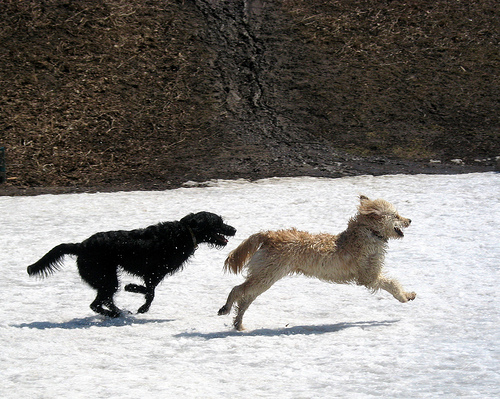

Two dogs running through a lying body of water .


In [ ]:
z = Image(filename=img)
display(z)

print(Argmax_Search)